# Weather file - visulization
- Main task: visualizing weather station locations, yield, & climatology of sites
- Main input:
    - weather station list & detail
    - USDA NASS maize yield data
    - compiled weater data (temp, rh, precip, solrad)
- Main output: 
    - weather stations map
    - yield map & station locations
    - climatology: temp & precip

In [1]:
import numpy as np
import pandas as pd
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import xarray as xr
import datetime
import seaborn as sns

from scipy.stats.stats import pearsonr
from palettable.colorbrewer.sequential import OrRd_6
from palettable.colorbrewer.sequential import YlGn_9
from palettable.colorbrewer.sequential import YlGnBu_8
from palettable.colorbrewer.sequential import RdPu_5

### Step 1. Figure out weather stations details
- Main task:
    - Read in site files from NSRD dataset - since these files include all the common sites across temp, precip and solrad
    - Create dataframe that has detail site info, including
        - site ID 
        - lat
        - lon
        - city
        - state
- Main input: /data/ISH_NSRD/**station_list_1961to1990.txt**
- Main output: /weadata/**site_info.csv**

In [48]:
sites = pd.read_csv('/home/disk/eos8/ach315/data/ISH_NSRD/station_list_1961to1990.txt', 
                    header= None, squeeze= True, dtype= str)

file_list = sites + "_62.txt" # only reading in files from year 1962, 
                              # since all sites are present for this year, 
                              # and a single year will provide all info needed for each site


WBAN_id = list()
cities = list()
states = list()
latitude = list()
longitude = list()

for i in file_list:
    solrad_file = pd.read_table('/home/disk/eos8/ach315/data/ISH_NSRD/1961to1990/' + 
                                str(i), squeeze= True, header= None)
    wban = solrad_file[0][1:6]
    WBAN_id.append(wban)
    
    city = solrad_file[0][7:29]
    cities.append(city)
    
    state = solrad_file[0][30:32]
    states.append(state)

    lat_degree = int(solrad_file[0][39:42])
    lat_minute = int(solrad_file[0][42:44])*0.01
    lat = lat_degree + lat_minute
    latitude.append(lat)
    
    lon_degree = int(solrad_file[0][47:50])
    lon_minute = int(solrad_file[0][51:53])*0.01
    lon = lon_degree + lon_minute
    longitude.append(lon)
    
site_info = pd.DataFrame({'site': WBAN_id,
                          'city': cities,
                          'state': states,
                          'lat': latitude,
                          'lon': longitude},
                         columns = ['site', 'city', 'state', 'lat', 'lon'])

#site_info.to_csv('/home/disk/eos8/ach315/upscale/weadata/site_info.csv')

### Step 2. Plot out weather station locations on map
- Mian input:
    - /weadata/**site_into.csv**
    - /weadata/**site_years.csv**
- Main output:
    - /figs/**sites_weastation.png**

In [2]:
df_siteinfo = pd.read_csv("/home/disk/eos8/ach315/upscale/weadata/site_info.csv", index_col=0, dtype=str)
site_years = pd.read_csv("/home/disk/eos8/ach315/upscale/weadata/site_years.csv", index_col=0, dtype=str)
df_siteyears = pd.merge(left=site_years, right=df_siteinfo, how="inner")
df_siteyears = df_siteyears[df_siteyears.site!='41415'] # exclunding Gwam
df_siteyears.head()

,site,years,city,state,lat,lon
0,03103,21,FLAGSTAFF,AZ,35.08,111.4
1,03812,20,ASHEVILLE,NC,35.26,82.32
2,03813,21,MACON,GA,32.42,83.39
3,03820,19,AUGUSTA,GA,33.22,81.58
4,03822,20,SAVANNAH,GA,32.08,81.12


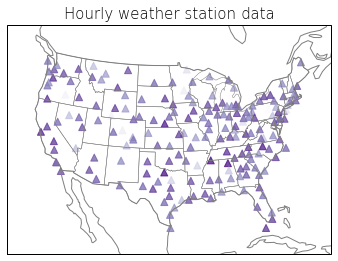

In [45]:
# creating map with weather station sites only
from palettable.colorbrewer.sequential import Purples_9

fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(1,1,1, projection=ccrs.AlbersEqualArea(
                         central_latitude=39.5, central_longitude=-98.35))
ax.set_extent([-123, -72, 19, 53])
ax.scatter(df_siteyears.lon.astype(float)*-1, df_siteyears.lat.astype(float), 
           transform=ccrs.PlateCarree(), s=50, marker='^', 
           c=df_siteyears.years.astype(float), cmap=Purples_9.mpl_colormap, alpha=0.7)

ax.add_feature(cfeature.BORDERS, edgecolor='grey')
ax.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
ax.set_title('Hourly weather station data', fontweight='light', fontsize=15)
fig.subplots_adjust(left=0.05, bottom=0, right=0.95, top=1)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/sites_weastation.png', format='png', dpi=800)

### Step 3. Overlay site locations with past yield data
- Main input:
    - /data/NASS_cropdata/**stateID.txt**
    - /data/NASS_cropdata/**countyID.txt**
    - /data/NASS_cropdata/**lat_county.txt**
    - /data/NASS_cropdata/**lon_county.txt**
    - /data/NASS_cropdata/**corn_yield.txt**
    - /data/NASS_cropdata/**corn_area.txt**   
- Main output:
    - /figs/**sites_obsyield.png**

#### 3.1 Reading in USDA NASS yield data

In [12]:
# Reading in state & county id
state_id = pd.read_csv("/home/disk/eos8/ach315/data/NASS_cropdata/stateID.txt", sep="\s+", header=None)
state_id = state_id.transpose()
state_id.columns = ["state_id"]
county_id = pd.read_csv("/home/disk/eos8/ach315/data/NASS_cropdata/countyID.txt", sep="\s+", header=None)
county_id = county_id.transpose()
county_id.columns = ["county_id"]

# Reading in lat & lon information
lat_county = pd.read_csv("/home/disk/eos8/ach315/data/NASS_cropdata/lat_county.txt", sep="\s+", header=None)
lat_county = lat_county.transpose()
lat_county.columns = ["lat"]
lon_county = pd.read_csv("/home/disk/eos8/ach315/data/NASS_cropdata/lon_county.txt", sep="\s+", header=None)
lon_county = lon_county.transpose()
lon_county.columns = ["lon"]

# Reading in maize yield
cornyield = pd.read_csv("/home/disk/eos8/ach315/data/NASS_cropdata/corn_yield.txt", sep="\s+", header=None)
years = np.arange(1910, 2015)
cornyield.columns = years

# Reading in maize area
cornarea = pd.read_csv("/home/disk/eos8/ach315/data/NASS_cropdata/corn_area.txt", sep="\s+", header=None)
years = np.arange(1910, 2015)
cornarea.columns = years
cornarea = cornarea.melt(var_name='year', value_name='area')
cornarea = cornarea.drop(['year'], axis=1)

# concatinating all information and melting dataframe
df = pd.concat([state_id, county_id, lat_county, lon_county, cornyield], axis=1)
df = pd.melt(df, id_vars=['state_id', 'county_id', 'lat', 'lon'], value_name='yield', var_name="year")
df = pd.concat([df, cornarea], axis=1)
print(df.shape)

(326340, 7)


#### 3.2 Subsetting data for year 1961-1990

In [13]:
df_subset = pd.DataFrame()
years = np.arange(1961,1991)

for i in range(len(years)):
    data = df[df['year'] == years[i]]
    df_subset = pd.concat([df_subset, data])

# calculating mean yield & area planted across 1961-1990
df_sitemean = df_subset.groupby(['state_id', 'county_id']).mean()
df_sitemean = df_sitemean.reset_index()

#### 3.3 Visualization

Text(0, 0.5, 'yield (tons/ha)')

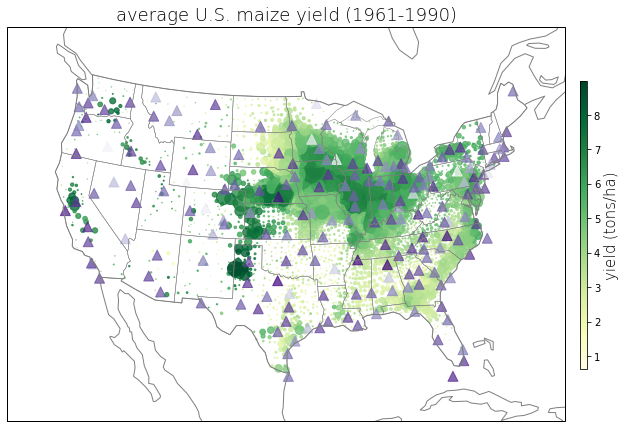

In [48]:
from palettable.colorbrewer.sequential import YlGn_9
from palettable.colorbrewer.sequential import Purples_9

lbperbu = 56
kgperlb = 0.453592
acreperha = 2.47105

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1,1,1, 
                     projection=ccrs.AlbersEqualArea(
                         central_latitude=39.5, central_longitude=-98.35))
ax.set_extent([-123, -72, 19, 53])
ax.scatter(df_sitemean['lon'], df_sitemean['lat'], 
           transform=ccrs.PlateCarree(), 
           c=df_sitemean['yield']*lbperbu*kgperlb/1000, s=df_sitemean['area']/200, 
           cmap=YlGn_9.mpl_colormap, alpha=0.8)

ax.scatter(df_siteyears.lon.astype(float)*-1, df_siteyears.lat.astype(float), 
           transform=ccrs.PlateCarree(), s=100, marker='^',
           c=df_siteyears.years.astype(float), cmap=Purples_9.mpl_colormap, alpha=0.7)
#ax.set_title('Site Locations', fontweight='light', fontsize=18)

ax.add_feature(cfeature.BORDERS, edgecolor='grey')
ax.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
ax.set_title('average U.S. maize yield (1961-1990)', 
              fontweight='light', fontsize=18)


yield_lim = np.array([[df_sitemean['yield'].min(), df_sitemean['yield'].max()]])
im1 = plt.imshow(yield_lim, cmap=YlGn_9.mpl_colormap)
im1.set_visible("False")
cb_ax1 = fig.add_axes([0.92, 0.25, 0.01, 0.5]) 
cb1 = plt.colorbar(im1, cax=cb_ax1)
cb1.ax.set_ylabel('yield (tons/ha)', fontweight='light', fontsize=15)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/sites_obsyield.png', format='png', dpi=800)

### Step 4. Climatology

In [14]:
# reading in weather data
df_temp = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/temp_all.csv', index_col= 0)
df_rh = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/rh_all.csv', index_col= 0)
df_precip = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/precip_all.csv', index_col= 0)
df_solrad = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/backup/solrad_all.csv', index_col= 0)
df_solrad = df_solrad.reindex(df_temp.index)

In [15]:
# listing sites to drop from dataset
df_siteinfo = pd.read_csv("/home/disk/eos8/ach315/upscale/weadata/site_info.csv", index_col=0, dtype=str)
sites_AK = df_siteinfo[df_siteinfo.state == 'AK'].site # excluding Alaska
sites_HI = df_siteinfo[df_siteinfo.state == 'HI'].site # excluding Hawaii
sites_PI = df_siteinfo[df_siteinfo.state == 'PI'].site # excluding Guam
drop_sites = list(sites_AK.append(sites_HI).append(sites_PI))

In [16]:
# reforming dataframes
df_temp = df_temp.drop(drop_sites, axis=1)
df_rh = df_rh.drop(drop_sites, axis=1)
df_precip = df_precip.drop(drop_sites, axis=1)
df_solrad = df_solrad.drop(drop_sites, axis=1)
df_siteinfo = df_siteinfo[df_siteinfo.state != 'AK'] # excluding Alaska
df_siteinfo = df_siteinfo[df_siteinfo.state != 'HI'] # excluding Hawaii
df_siteinfo = df_siteinfo[df_siteinfo.state != 'PI'] # excluding GUAM

In [17]:
# putting together xr.Dataset
timepoints = pd.to_datetime(df_temp.index)
sites = df_temp.columns

ds_wea = xr.Dataset({'temp': (['time', 'site'], df_temp),
                     'precip': (['time', 'site'], df_precip),
                     'rh': (['time', 'site'], df_rh),
                     'solrad': (['time', 'site'], df_solrad)},
                    coords= {'time': timepoints, 
                             'site': sites,
                             'lat': df_siteinfo.lat.astype(float), 
                             'lon': df_siteinfo.lon.astype(float)})

ds_wea

<xarray.Dataset>
Dimensions:  (dim_0: 215, site: 215, time: 197310)
Coordinates:
  * time     (time) datetime64[ns] 1961-03-01 1961-03-01T01:00:00 ... 1990-11-30
  * site     (site) object '03103' '03812' '03813' ... '94849' '94860' '94910'
  * dim_0    (dim_0) int64 0 1 2 3 4 5 6 7 8 ... 229 230 231 232 233 234 235 236
    lat      (dim_0) float64 35.08 35.26 32.42 33.22 ... 42.25 45.04 42.53 42.33
    lon      (dim_0) float64 111.4 82.32 83.39 81.58 ... 83.01 83.34 85.31 92.24
Data variables:
    temp     (time, site) float64 nan 12.2 21.7 21.1 18.9 ... nan nan nan 1.7
    precip   (time, site) float64 nan nan 0.0 0.0 0.0 ... nan nan nan nan 0.0
    rh       (time, site) float64 nan 61.14 60.67 67.7 ... nan nan nan 66.34
    solrad   (time, site) float64 nan 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

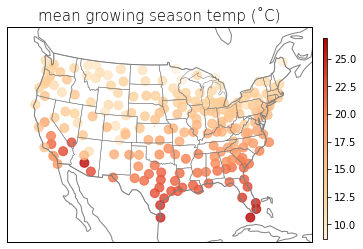

In [25]:
fig = plt.figure(figsize=(12,8))
extent = [-123, -72, 19, 53]

# plotting temperature
ax1 = fig.add_subplot(1,2,1, projection=ccrs.AlbersEqualArea(central_latitude=39.5, central_longitude=-98.35))
ax1.set_extent(extent)
ax1.scatter(ds_wea.lon.astype(float)*-1, ds_wea.lat.astype(float), 
            transform=ccrs.PlateCarree(), c= ds_wea.mean('time').temp, s=80,
            cmap=OrRd_6.mpl_colormap, alpha= 0.8)

ax1.add_feature(cfeature.BORDERS, edgecolor='grey')
ax1.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax1.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
ax1.set_title('mean growing season temp (˚C)', 
              fontweight='light', fontsize=15)

lim = np.array([[ds_wea.mean('time').temp.min(), ds_wea.mean('time').temp.max()]])
im1 = plt.imshow(lim, cmap=OrRd_6.mpl_colormap)
im1.set_visible("False")
cb_ax1 = fig.add_axes([0.49, 0.32, 0.005, 0.35])
cb1 = plt.colorbar(im1, cax=cb_ax1)


In [44]:
# gathering weather data from all site-years and putting into xarray
years = np.arange(1961,1991)
cols = ['year', 'precip', 'temp', 'rh', 'site', 'lat', 'lon']
df_wea = pd.DataFrame(columns = cols)

for i in years:
    df_year = pd.DataFrame({'year': str(i),
                            'precip': ds_wea.sel(time=slice(str(i)+'-04-01', str(i)+'-10-31')).precip.sum(dim='time'),
                            'temp': ds_wea.sel(time=slice(str(i)+'-04-01', str(i)+'-10-31')).temp.mean(dim='time'),
                            'rh': ds_wea.sel(time=slice(str(i)+'-04-01', str(i)+'-10-31')).rh.mean(dim='time'),
                            'site': ds_wea.site, 'lat': ds_wea.lat, 'lon': ds_wea.lon})
    df_wea = pd.concat([df_wea, df_year])

df_wea = df_wea.drop(['lat', 'lon'], axis=1)

/home/disk/eos8/ach315/anaconda3/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


200506 - still need to plot in precip